# Results visualization

Within Excel, the manual evaluation of the model answers was done by coloring each cell. The colors are extracted in this notebook and stored in a pandas dataframe. The colors are recoded to meaningful names, and the accuracy of the model answers is calculated. The results are visualized in multiple ways.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import load_workbook

### Import and load the workbook

In [2]:
# import xlsx, decode cell color to new columns
path = '../Results/model_answers_manual_eval.xlsx'
wb = load_workbook(path, data_only=True)
sh = wb['Scoring_eval']

In [3]:
# define function to extract color from each cell of a column, and store in a list
def get_colour_list(sheet, column: str, start_row: int, end_row: int) -> list:
    return [sheet[f'{column}{i}'].fill.start_color.index for i in range(start_row, end_row + 1)]

In [4]:
# Use the function to extract the colors of the columns
column_labels = {
    'F': 'ooo', 'G': 'ooF', 'H': 'oRo', 'I': 'Poo', 
    'J': 'oRF', 'K': 'PRo', 'L': 'PoF', 'M': 'PRF'
}
color_lists = {column_labels[col]: get_colour_list(sh, col, 2, 352) for col in column_labels.keys()}

In [5]:
# Convert lists into a df
df_colours = pd.DataFrame(color_lists)

In [6]:
# create dict to recode color codes to meaningful names
color_to_meaning = {6: 'correct', # pastel green
                    5: 'incorrect', # pastel red
                    8: 'correct, not following format', # pastel blue
                    9: 'incorrect, but following format', # pastel orange
                    '00000000': 'no answer given', # white
                    1: 'not enough context for models to answer (external framework score)', # black
                    }

In [7]:
# recode color codes to meaningful names
df_colours = df_colours.replace(color_to_meaning)

In [8]:
df_colours

,ooo,ooF,oRo,Poo,oRF,PRo,PoF,PRF
0,correct,incorrect,incorrect,correct,"correct, not following format","incorrect, but following format","incorrect, but following format",incorrect
1,"incorrect, but following format","incorrect, but following format","incorrect, but following format",incorrect,no answer given,no answer given,no answer given,"incorrect, but following format"
2,"incorrect, but following format",incorrect,"incorrect, but following format",incorrect,incorrect,no answer given,no answer given,"incorrect, but following format"
3,incorrect,"incorrect, but following format",incorrect,"incorrect, but following format",incorrect,no answer given,"incorrect, but following format",no answer given
4,incorrect,incorrect,incorrect,"incorrect, but following format",incorrect,"incorrect, but following format","incorrect, but following format",incorrect
...,...,...,...,...,...,...,...,...
346,incorrect,incorrect,correct,correct,incorrect,correct,incorrect,incorrect
347,correct,incorrect,incorrect,"incorrect, but following format","correct, not following format","incorrect, but following format","incorrect, but following format","incorrect, but following format"
348,incorrect,incorrect,incorrect,incorrect,incorrect,no answer given,no answer given,incorrect
349,"correct, not following format","correct, not following format",correct,correct,"correct, not following format",correct,correct,correct


In [9]:
len(df_colours)

351

### Analysis of the results

Calculating the accuracy of the model answers

In [10]:
# make table with the value counts of all columns
categories = df_colours.apply(pd.Series.value_counts, normalize=True).fillna(0).T

In [11]:
# entries are correct if they are either 'correct' or 'correct, not following format'. Calculate the accuracy of each column (NOT ENOUGH CONTEXT NOT TAKEN INTO ACCOUNT)
categories['accuracy'] = ( categories['correct'] + categories['correct, not following format'] ) / (categories['correct'] + categories['correct, not following format'] + categories['incorrect'] + categories['incorrect, but following format'] + categories['no answer given'] )

In [12]:
print(categories[['accuracy']])

     accuracy
ooo  0.216763
ooF  0.130058
oRo  0.182081
Poo  0.277457
oRF  0.193642
PRo  0.210983
PoF  0.289017
PRF  0.112717


Visualizing the accuracy of the model answers

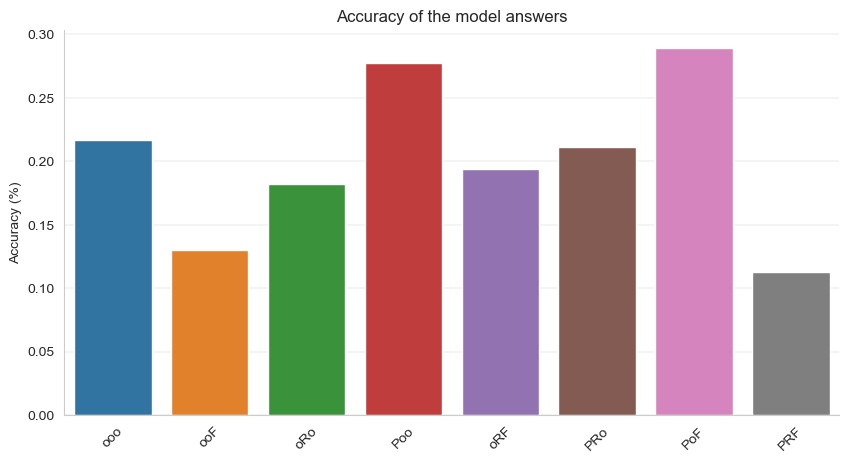

In [13]:
# plot the accuracy of the model answers
plt.figure(figsize=(10, 5))
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.25, alpha=0.5)
sns.barplot(x=categories.index, y='accuracy', data=categories)
sns.despine()
plt.xticks(rotation=45)
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of the model answers')
plt.show()

Visualizing the distribution of the model answers

In [38]:
# Custom color mapping for plotting
plot_colors = [
    "#A9CBB7",  # pastel green
    "#C2D4DD",  # pastel blue
    "#F4B2B0",  # pastel red
    "#FAD4A5",  # pastel orange
    "#A9A9A9",  # dark grey
    "#D3D3D3"   # light grey
]

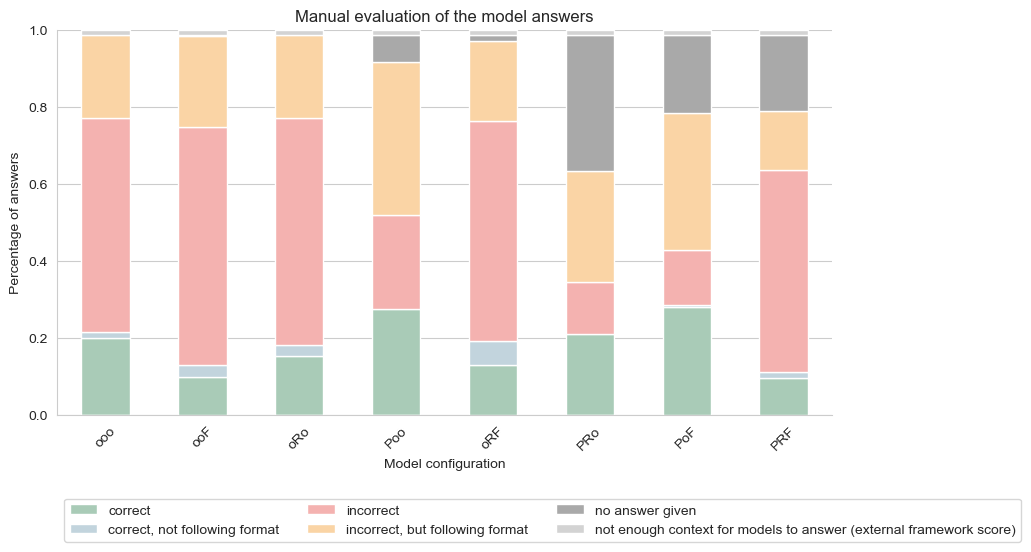

In [40]:
# plot the distribution of the model answers
fig, ax = plt.subplots(figsize=(10, 5))
categories.drop(columns='accuracy').plot(kind='bar', stacked=True, color=plot_colors, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Manual evaluation of the model answers')
ax.set_ylabel('Percentage of answers')
ax.set_xlabel('Model configuration')
ax.set_ylim(0, 1)
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.2), ncol=3)
plt.xticks(rotation=45)
plt.savefig('manual_eval_soft.png', bbox_inches='tight')
plt.show()

Heatmap of the model answers

In [70]:
# remove rows from df_colour with 'not enough context for models to answer (external framework score)'
df_colours2 = df_colours[df_colours['ooo'] != 'not enough context for models to answer (external framework score)']

In [71]:
category_mapping = {
    'correct': 2,
    'correct, not following format': 1,
    'no answer given': 0,
    'incorrect': -1,
    'incorrect, but following format': -2,
}

In [72]:
df_numeric = df_colours2.replace(category_mapping)

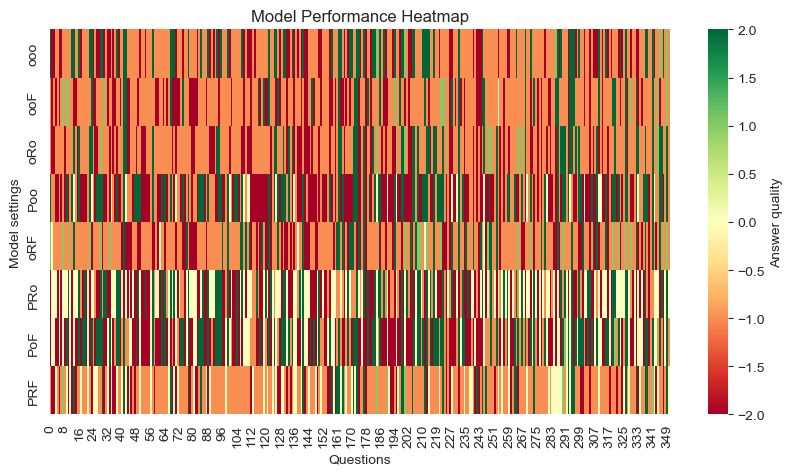

In [73]:
# plot the heatmap of the model answers
plt.figure(figsize=(10, 5))
sns.heatmap(df_numeric.T, cmap="RdYlGn", cbar_kws={'label': 'Answer quality'})
plt.title('Model Performance Heatmap')
plt.ylabel('Model settings')
plt.xlabel('Questions')
plt.show()

Analyzing accuracy and performance of only multiple choice questions

In [75]:
# read column from the original excel sheet (text) 
multiple_choice = sh['D'][1:352]
multiple_choice = [cell.value for cell in multiple_choice]

df_colours_MC = df_colours.copy()

# add multiple choice column to the df
df_colours_MC['multiple_choice'] = multiple_choice
# place the multiple choice column at the beginning of the df
df_colours_MC = df_colours_MC[['multiple_choice', 'ooo', 'ooF', 'oRo', 'Poo', 'oRF', 'PRo', 'PoF', 'PRF']]
# keep only rows with multiple choice questions (start with '0')
df_colours_MC = df_colours_MC.loc[df_colours_MC['multiple_choice'].str.startswith('0')]
# reset the index and drop the multiple choice column
df_colours_MC = df_colours_MC.reset_index(drop=True)

In [76]:
# change cells to only correct or incorrect
df_colours_MC = df_colours_MC.replace({'correct, not following format': 'correct', 'incorrect, but following format': 'incorrect', 'no answer given': 'incorrect'})

In [77]:
# determine how many multiple choice answer options there are in each question, and recode the multiple choice column to the number of options
for i in range(len(df_colours_MC)):
    if '4' in df_colours_MC.loc[i, 'multiple_choice']:
        df_colours_MC.loc[i, 'multiple_choice'] = 5
    elif '3' in df_colours_MC.loc[i, 'multiple_choice']:
        df_colours_MC.loc[i, 'multiple_choice'] = 4
    elif '2' in df_colours_MC.loc[i, 'multiple_choice']:
        df_colours_MC.loc[i, 'multiple_choice'] = 3
    elif '1' in df_colours_MC.loc[i, 'multiple_choice']:
        df_colours_MC.loc[i, 'multiple_choice'] = 2

In [78]:
df_colours_MC.head()

,multiple_choice,ooo,ooF,oRo,Poo,oRF,PRo,PoF,PRF
0,3,correct,incorrect,incorrect,correct,correct,incorrect,incorrect,incorrect
1,4,incorrect,incorrect,incorrect,incorrect,incorrect,incorrect,incorrect,incorrect
2,4,incorrect,incorrect,incorrect,incorrect,incorrect,incorrect,incorrect,incorrect
3,5,incorrect,incorrect,incorrect,incorrect,incorrect,incorrect,incorrect,incorrect
4,3,incorrect,correct,incorrect,correct,incorrect,incorrect,correct,incorrect


In [90]:
# count the number of each option in the multiple choice column
df_colours_MC['multiple_choice'].value_counts()

multiple_choice
3    97
2    65
4    31
5     7
Name: count, dtype: int64

In [79]:
len(df_colours_MC)

200

In [89]:
# First calculate model accuracies
model_accuracies_MC = df_colours_MC.drop(columns='multiple_choice').apply(lambda x: x[x == 'correct'].count() / x.count())
model_accuracies_MC

ooo    0.280
ooF    0.165
oRo    0.220
Poo    0.455
oRF    0.255
PRo    0.345
PoF    0.480
PRF    0.145
dtype: float64

In [81]:
# random accuracy based on the number of options
random_accuracy_map = {2: 0.5, 3: 1/3, 4: 0.25, 5: 0.2}
df_colours_MC['random_accuracy'] = df_colours_MC['multiple_choice'].map(random_accuracy_map)
# calculate the expected random accuracy
expected_random_accuracy = df_colours_MC['random_accuracy'].mean()
print(f'Random accuracy: {expected_random_accuracy:.3f}')

Random accuracy: 0.370


In [82]:
# Compare model accuracies against the expected random accuracy
comparison = model_accuracies_MC > expected_random_accuracy

# Prepare the results in a DataFrame for nicer display
results_df = pd.DataFrame({
    'Model Accuracy': model_accuracies_MC,
    'Random Chance Accuracy': expected_random_accuracy,
    'Better Than Random': comparison
})

# Define a function for styling
def highlight_better_than_random(s):
    return ['background-color: #77DD77' if v else '' for v in s]

# Apply the styling
styled_results = results_df.style.apply(highlight_better_than_random, subset=['Better Than Random'])
# only three decimals except 'better than random'
styled_results.format("{:.3f}", subset=['Model Accuracy', 'Random Chance Accuracy'])
styled_results

,Model Accuracy,Random Chance Accuracy,Better Than Random
ooo,0.280,0.370,False
ooF,0.165,0.370,False
oRo,0.220,0.370,False
Poo,0.455,0.370,True
oRF,0.255,0.370,False
PRo,0.345,0.370,False
PoF,0.480,0.370,True
PRF,0.145,0.370,False


Chi-square test to determine if the model accuracies are significantly different from random chance

In [83]:
from scipy.stats import chi2_contingency

In [84]:
# remove rows with 'not enough context for models to answer (external framework score)'
df_colours_MC_chi = df_colours_MC[df_colours_MC['ooo'] != 'not enough context for models to answer (external framework score)'].drop(columns='random_accuracy')

In [85]:
# remove multiple choice column and reset index
contingency_table = df_colours_MC_chi.drop(columns='multiple_choice').apply(pd.Series.value_counts).fillna(0)
contingency_table

,ooo,ooF,oRo,Poo,oRF,PRo,PoF,PRF
incorrect,139,162,151,104,144,126,99,166
correct,56,33,44,91,51,69,96,29


In [86]:
# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

In [87]:
# Display the results
print(f'Chi-square: {chi2:.3f}')
print(f'p-value: {p:.3f}')
print(f'Degrees of freedom: {dof}')

print('\nExpected values:\n\n', pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

Chi-square: 106.485
p-value: 0.000
Degrees of freedom: 7

Expected values:

                ooo      ooF      oRo      Poo      oRF      PRo      PoF  \
incorrect  136.375  136.375  136.375  136.375  136.375  136.375  136.375   
correct     58.625   58.625   58.625   58.625   58.625   58.625   58.625   

               PRF  
incorrect  136.375  
correct     58.625  


**Chi-Square Test Results Interpretation**
- *Chi-Square Statistic: 106.485*
This value is quite high, indicating a strong deviation between the observed counts of 'correct' and 'incorrect' answers and what we would expect if there were no association between model settings (ooo, ooF, etc.) and answer correctness.
- *P-value: 0.000*
A p-value of 0.000 suggests that the differences in model performances are highly significant statistically. In practical terms, this means that there is almost no chance that these differences in model accuracies are occurring due to random variation alone.
- *Degrees of Freedom: 7*
The degrees of freedom for this test, calculated as (Number of Rows − 1) × (Number of Columns − 1), indicate that there are sufficient data points to validate the reliability of the test results.

Model performance by number of answer options (still MC)

In [88]:
# drop random_accuracy column
df_colours_MC = df_colours_MC.drop(columns='random_accuracy')

# Convert 'correct'/'incorrect' to 1/0 for easier calculation
df_numeric = df_colours_MC.drop(columns='multiple_choice').applymap(lambda x: 1 if x == 'correct' else 0)

# Add the 'multiple_choice' column back for grouping
df_numeric['multiple_choice'] = df_colours_MC['multiple_choice']

# Calculate accuracy per number of options for each model
accuracy_per_option = df_numeric.groupby('multiple_choice').mean()

# Display the results
accuracy_per_option

,ooo,ooF,oRo,Poo,oRF,PRo,PoF,PRF
multiple_choice,,,,,,,,
2,0.400000,0.200000,0.323077,0.461538,0.369231,0.307692,0.476923,0.246154
3,0.278351,0.164948,0.206186,0.494845,0.257732,0.360825,0.463918,0.123711
4,0.032258,0.096774,0.064516,0.322581,0.064516,0.354839,0.548387,0.000000
5,0.285714,0.142857,0.142857,0.428571,0.000000,0.428571,0.428571,0.142857
